# Building a Time Series Forecasting Module From Scratch

## Importing Modules

In [1]:
import glob
import warnings
import pandas as pd
import numpy as np
import matplotlib as mpl
import statsmodels as sm
import tensorflow as tf
from datetime import datetime
from matplotlib import pyplot as plt
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] =12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

/Users/qab/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/qab/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Data Loading and Preparation

In [2]:
class Data_Prep:
    def __init__(self, dataset):
        self.data = dataset
    
    def del_cols(self):
        cols_not_needed = ['D-J-F', 'M-A-M', 'J-J-A', 'S-O-N', 'metANN']
        self.data = self.data.drop(cols_not_needed, axis = 1)
        return self
    
    def get_data(self):
        timeseries_data = []
        unique_years = self.data['YEAR'].unique()
        col = list(self.data.columns[1:])
        timeseries_dictionary = {}
        for i in unique_years:
            for j in range(1, 13): 
                timeseries_data.append([datetime(i, j, 1), float(self.data[self.data['YEAR'] == i][col[j-1]])])
        self.data = pd.DataFrame(timeseries_data, columns=['date', 'temp'])    
        return self
    
    def get_city(self, state):
        self.data['state'] = state
        return self
    
    def wrap_data(self):
        return self.data

In [3]:
path = r'./Temperature Data - Ghana'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    city = filename
    city = city.split('_')[1].split('.')[0]
    df = Data_Prep(df).del_cols().get_data().get_city(city).wrap_data()
    li.append(df)
    
city_frame = pd.concat(li, axis=0, ignore_index=True)

In [4]:
city_frame

,date,temp,state
0,1943-01-01,999.90,kumasi
1,1943-02-01,999.90,kumasi
2,1943-03-01,999.90,kumasi
3,1943-04-01,999.90,kumasi
4,1943-05-01,999.90,kumasi
...,...,...,...
1339,2020-08-01,25.45,accra
1340,2020-09-01,25.87,accra
1341,2020-10-01,26.85,accra
1342,2020-11-01,28.08,accra


In [5]:
city_frame.loc[(city_frame.temp == 999.9)]

,date,temp,state
0,1943-01-01,999.9,kumasi
1,1943-02-01,999.9,kumasi
2,1943-03-01,999.9,kumasi
3,1943-04-01,999.9,kumasi
4,1943-05-01,999.9,kumasi
...,...,...,...
1275,2015-04-01,999.9,accra
1276,2015-05-01,999.9,accra
1294,2016-11-01,999.9,accra
1295,2016-12-01,999.9,accra


In [6]:
city_frame.describe()

,temp
count,1344.000000
mean,316.890112
std,445.560237
min,22.920000
25%,25.860000
50%,27.280000
75%,999.900000
max,999.900000


In [7]:
city_frame.loc[(city_frame.temp == 999.9),'temp']= city_frame.median()
city_frame.fillna(city_frame.median(), inplace=True)

In [8]:
city_frame.describe()

,temp
count,1344.000000
mean,26.436622
std,1.158265
min,22.920000
25%,25.860000
50%,26.410000
75%,26.982500
max,30.130000


In [9]:
city_frame.state.unique()

array(['kumasi', 'accra'], dtype=object)

In [10]:
city_1 = city_frame.loc[(city_frame.state == 'kumasi')]

In [11]:
city_1

,date,temp,state
0,1943-01-01,26.41,kumasi
1,1943-02-01,26.41,kumasi
2,1943-03-01,26.41,kumasi
3,1943-04-01,26.41,kumasi
4,1943-05-01,26.41,kumasi
...,...,...,...
931,2020-08-01,25.95,kumasi
932,2020-09-01,26.39,kumasi
933,2020-10-01,27.11,kumasi
934,2020-11-01,28.28,kumasi


In [12]:
city_1 = city_1.set_index('date')

In [13]:
city_1

,temp,state
date,,
1943-01-01,26.41,kumasi
1943-02-01,26.41,kumasi
1943-03-01,26.41,kumasi
1943-04-01,26.41,kumasi
1943-05-01,26.41,kumasi
...,...,...
2020-08-01,25.95,kumasi
2020-09-01,26.39,kumasi
2020-10-01,27.11,kumasi


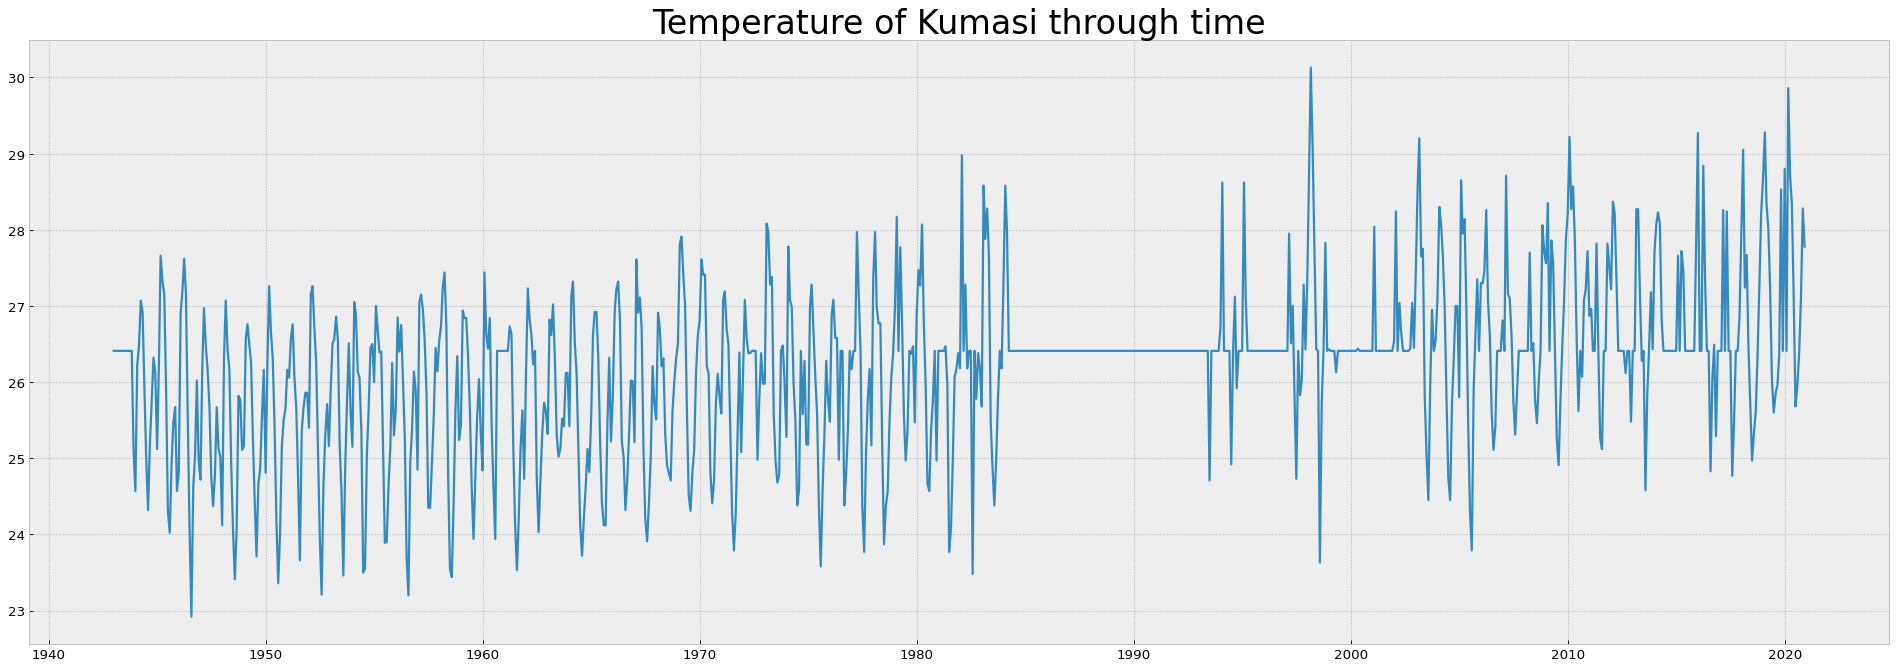

In [14]:
plt.figure(num = None, figsize = (30, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Temperature of Kumasi through time', fontsize = 30)
plt.plot(city_1['temp'])

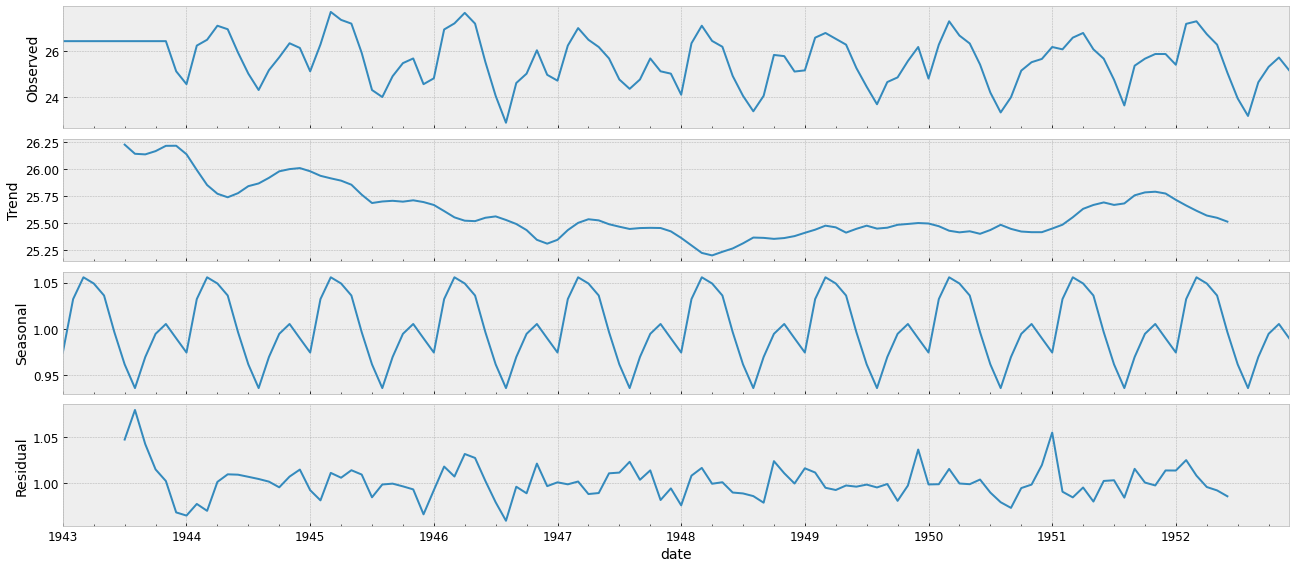

<Figure size 4000x1600 with 0 Axes>

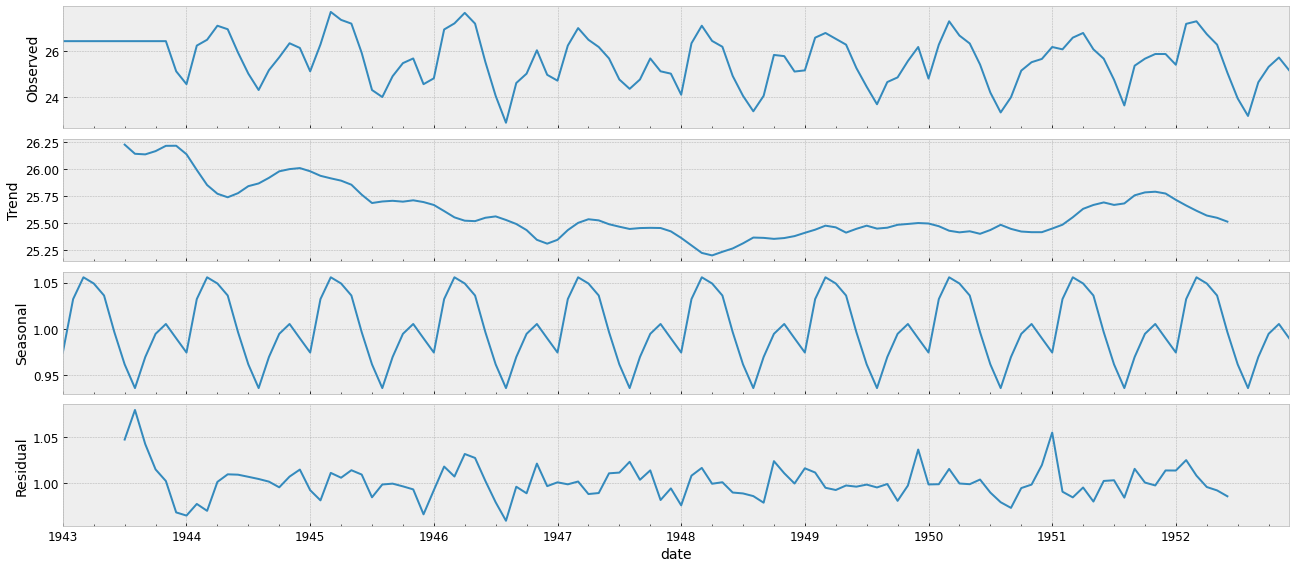

In [15]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num = None, figsize = (50, 20), dpi = 80, facecolor = 'w', edgecolor = 'k')
result = seasonal_decompose(city_1.temp[:120], model = 'multiplicative')
result.plot()

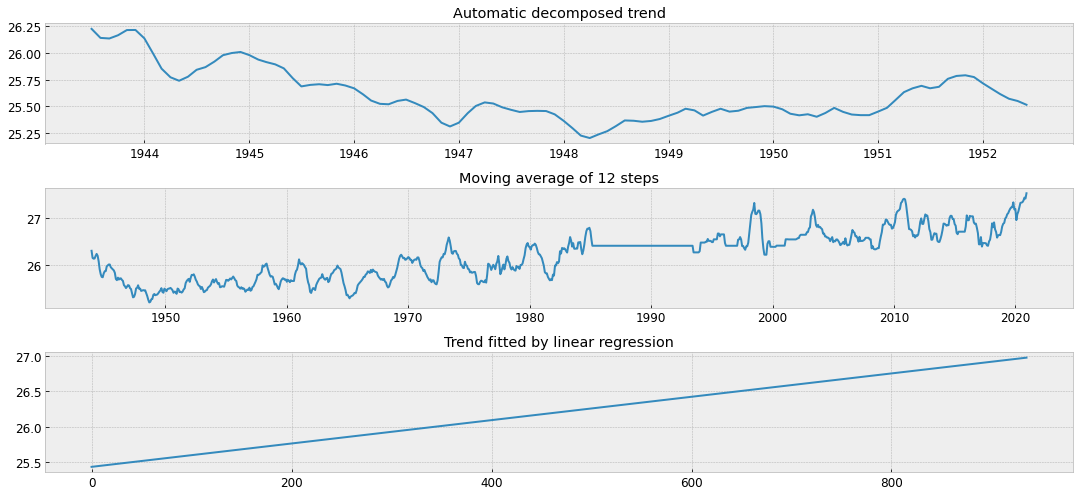

In [16]:
fig = plt.figure(figsize = (15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan = 2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan = 2)
pm_ax.plot(result.trend)
pm_ax.set_title('Automatic decomposed trend')
mm = city_1.temp.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title('Moving average of 12 steps')
X = [i for i in range(0, len(city_1['temp']))]
X = np.reshape(X, (len(X), 1))
y = city_1['temp'].values
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title('Trend fitted by linear regression')
plt.tight_layout()

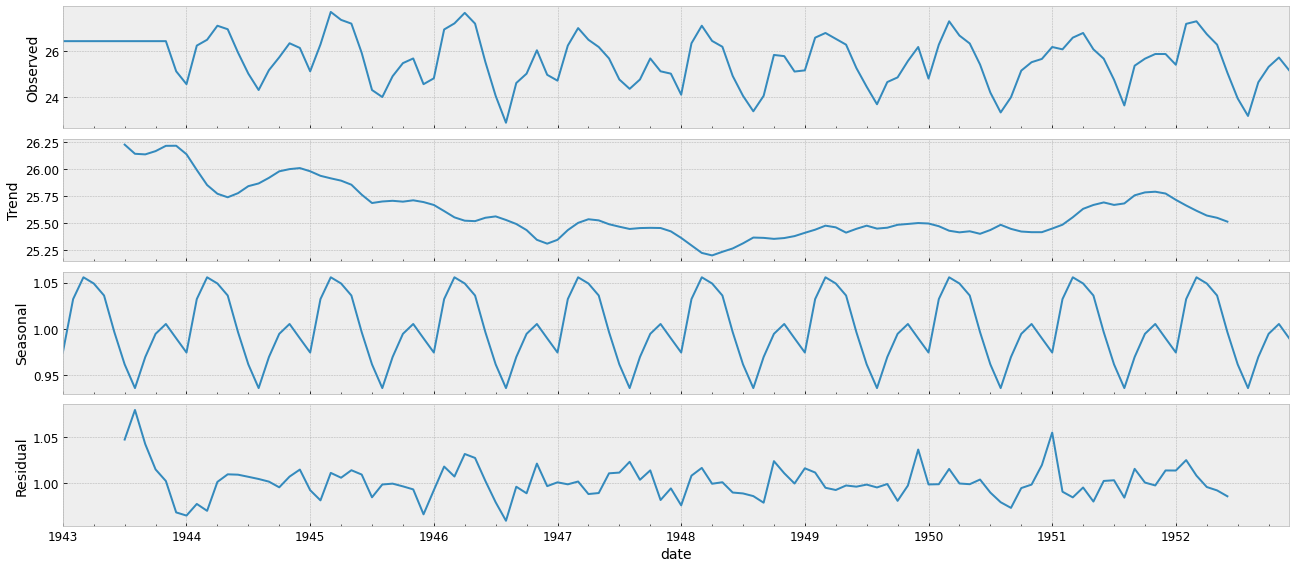

<Figure size 4000x1600 with 0 Axes>

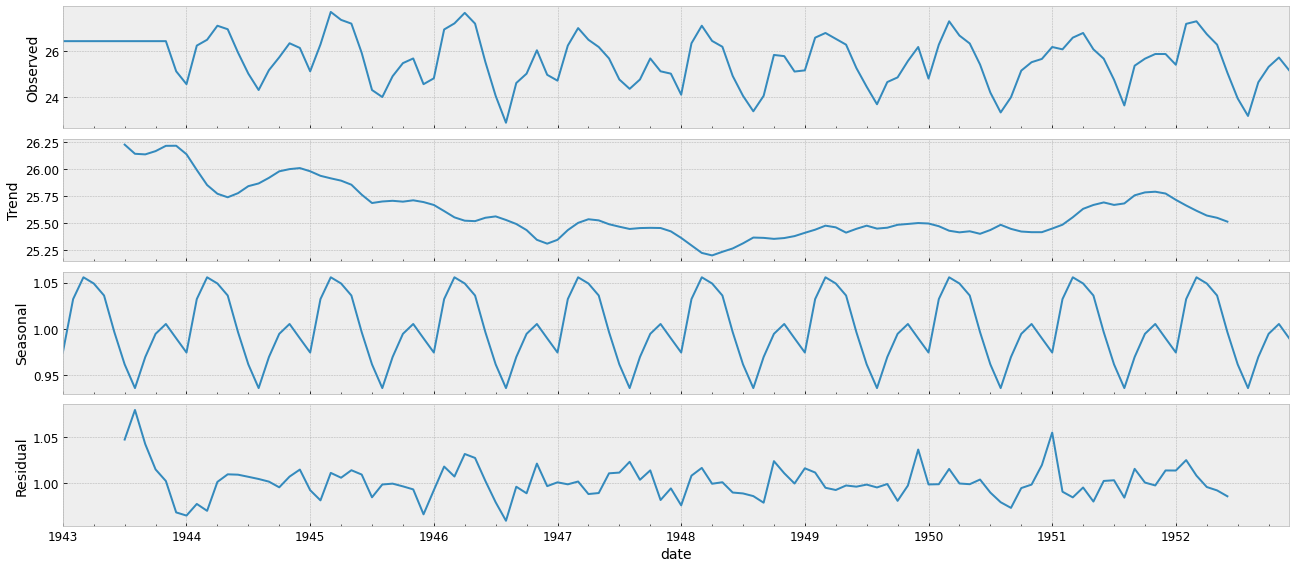

In [17]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num = None, figsize = (50, 20), dpi = 80, facecolor = 'w', edgecolor = 'k')
result = seasonal_decompose(city_1.temp[:120], model = 'multiplicative')
result.plot()

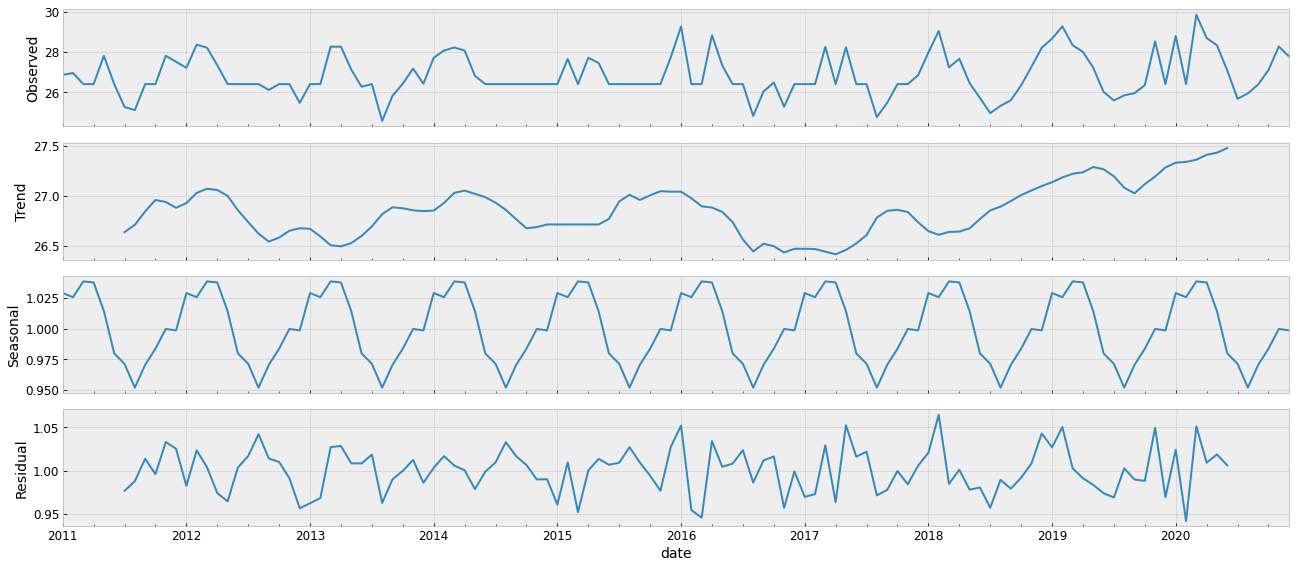

<Figure size 4000x1600 with 0 Axes>

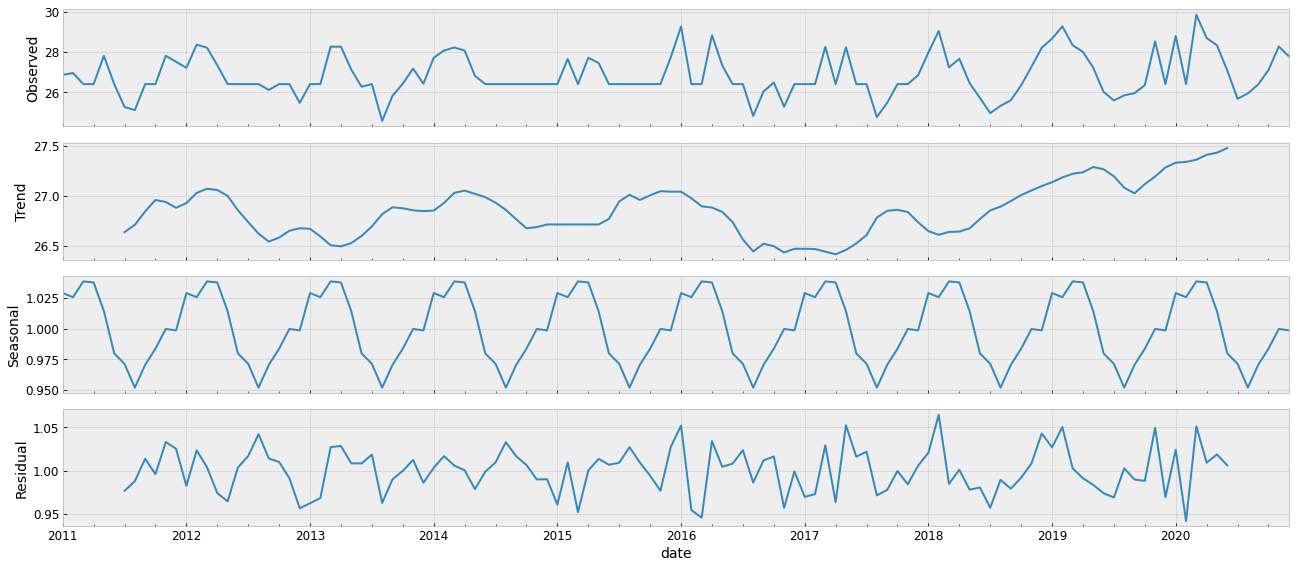

In [18]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num = None, figsize = (50, 20), dpi = 80, facecolor = 'w', edgecolor = 'k')
result = seasonal_decompose(city_1.temp[-120:], model = 'multiplicative')
result.plot()

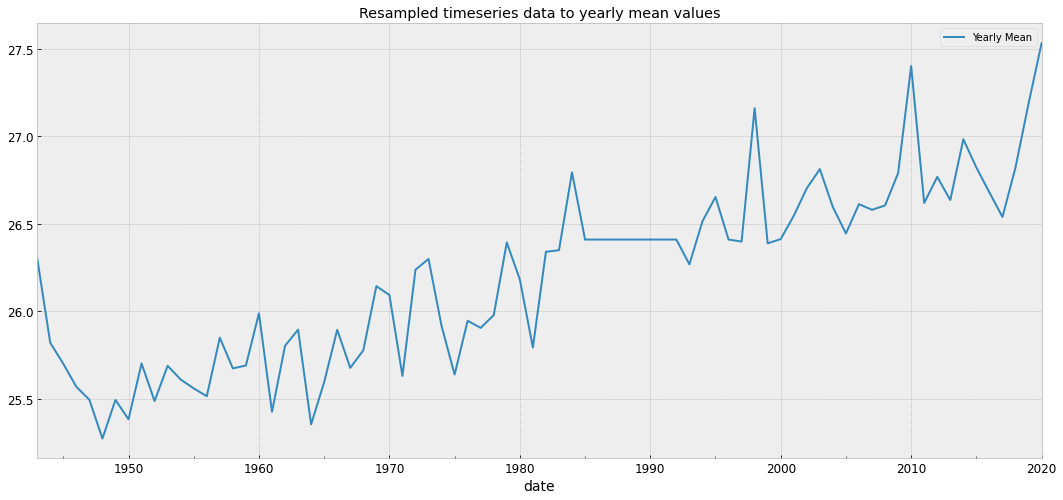

In [19]:
resample = city_1.resample('Y')
yearly_mean = resample.mean()
yearly_mean.temp.plot(label = 'Yearly Mean')
plt.title('Resampled timeseries data to yearly mean values')
plt.legend()

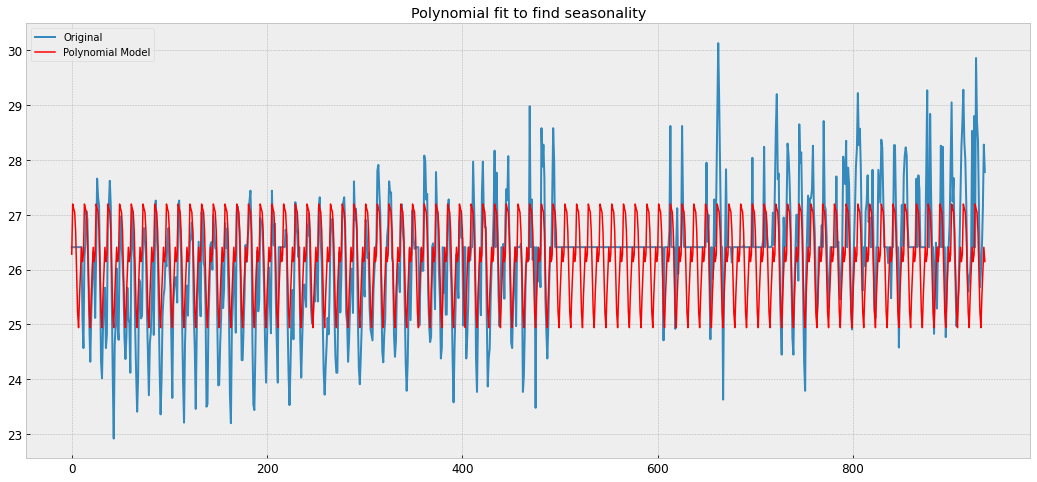

In [20]:
series = city_1['temp'].values
X = [i % 12 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i] ** (degree - d) * coef[d]
    curve.append(value)
plt.plot(series, label = 'Original')
plt.plot(curve, color = 'red', linewidth = 1.5, label = 'Polynomial Model')
plt.legend()
plt.title('Polynomial fit to find seasonality')
plt.show()

Text(0.5, 1.0, 'Mean over time')

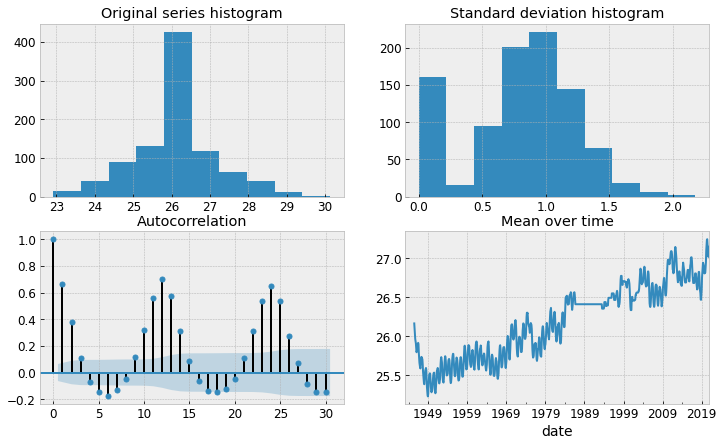

In [22]:
fig = plt.figure(figsize = (12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))
city_1['temp'].hist(ax = hist_ax)
hist_ax.set_title('Original series histogram')
plot_acf(series, lags = 30, ax = ac_ax)
ac_ax.set_title('Autocorrelation')
mm = city_1['temp'].rolling(7).std()
mm.hist(ax = hist_std_ax)
hist_std_ax.set_title('Standard deviation histogram')
mm = city_1['temp'].rolling(30).mean()
mm.plot(ax = mean_ax)
mean_ax.set_title('Mean over time')

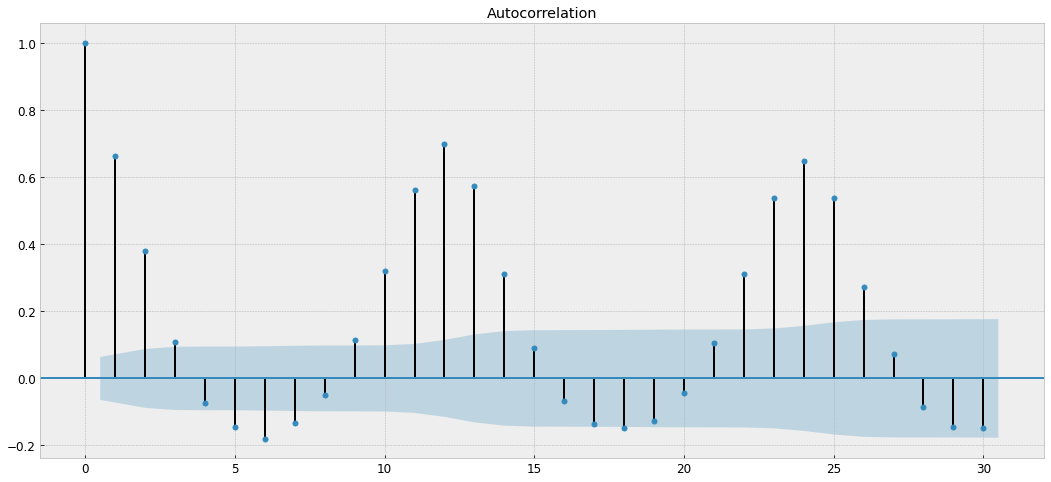

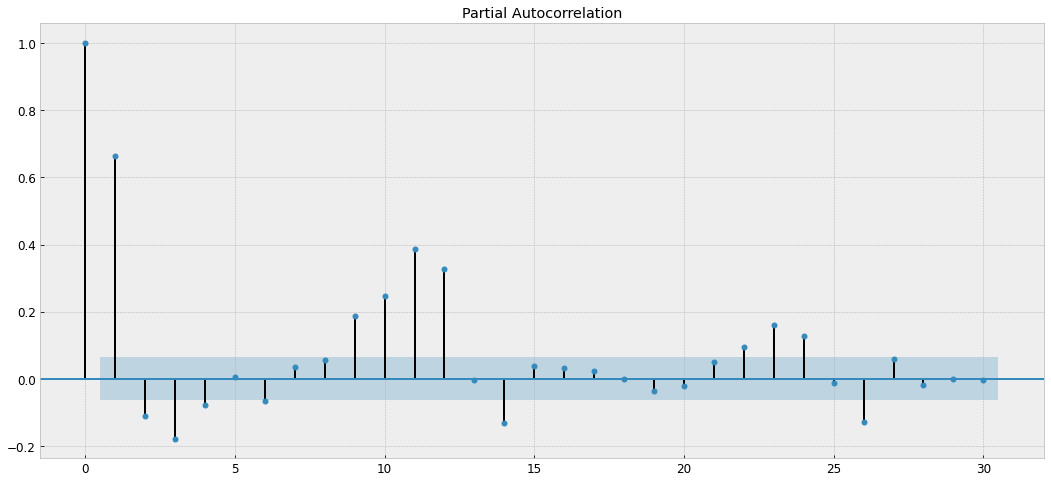

In [23]:
plot_acf(series, lags = 30)
plot_pacf(series, lags = 30)
plt.show()

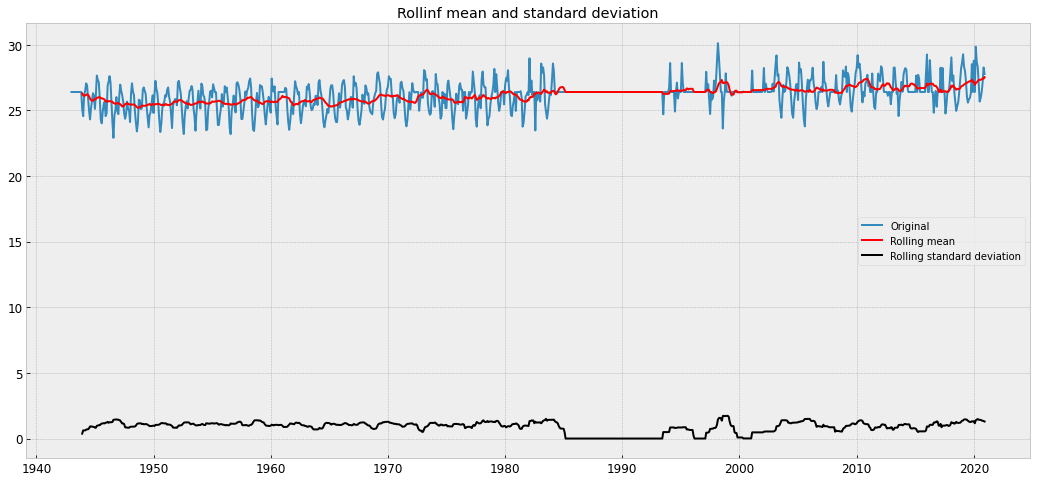

In [32]:
rol_mean = city_1['temp'].rolling(window = 12).mean()
rol_std = city_1['temp'].rolling(window = 12).std()
orig = plt.plot(city_1['temp'], label = 'Original')
mean = plt.plot(rol_mean, color = 'red', label = 'Rolling mean')
std = plt.plot(rol_std, color = 'black', label = 'Rolling standard deviation')
plt.legend(loc = 'best')
plt.title('Rollinf mean and standard deviation')
plt.show(block = False)

In [29]:
city_1.describe()

,temp
count,936.000000
mean,26.205331
std,1.069619
min,22.920000
25%,25.610000
50%,26.410000
75%,26.550000
max,30.130000
